<h1 style="text-align:center;">Permutationally Invariant Network for Enhanced Sampling (PINES)</h1>

# Introduction
Permutationally Invariant Network for Enhanced Sampling (PINES) is a data-driven method for automatically discovering high variance collective variables (CVs) and enhanced sampling to obtain free energy landscapes of single and multi-component molecular systems. It can be conceived as a permutationally invariant extension to the Molecular Enhanced Sampling with Autoencoders (MESA) method. PINES comprises four main components (Fig. 1):

1. Initial seed data: Unbiased or biased molecular dynamics (MD) simulations. In the initial iteration, biasing can be done using intuitive CVs or tempering methods.
2. Permutation Invariant Vector (PIV) featurization (F):  Translationally, rotationally, and permutationally invariant representation of the molecular system.
3. Universal function approximators (Autoencoders): Discovery of high-variance CVs {($\xi_1$, $\xi_2$, ...)}
4. MD simulations with CV biasing method: An enhanced sampling MD simulation of the system by biasing along the high variance CVs learned by the autoencoders to improve sampling of the system. In this tutorial, we use Parallel-Bias Metadynamics (PBMetaD), but any CV-enhanced sampling technique can be employed.


<figure align="center">
  <img src="./notebook_src/pines1.png" alt="PINES overview">
  <figcaption>Fig. 1:  Overview of PINES workflow to determine free energy landscapes of both single and multi-molecular systems. (a) Illustration of either initial seed MD or CV-biased MD simulation during PINES iterations. The snapshot shows a representation of a NaCl system configuration in water with Na, Cl, O, and H colored in yellow, green, red, and white, respectively. (b) Post-processing of the system configurations sampled during MD simulation in Cartesian space for PIV featurization. {x<sub>i</sub>, y<sub>i</sub>, z<sub>i</sub>} represent the x, y, and z positions of atom i in the system. (c) PIV featurization to remove translation, rotational, and permutational symmetries in the system. (d) Learning differentiable and high-variance nonlinear CVs using autoencoders. We use a feed-forward network as a universal function approximator for the autoencoders' encoder and decoder parts. (e) Principal component analysis to align the manifold discovered using autoencoders with the highest variance directions. (f) Enhanced sampling along the discovered whitened CVs or termination of PINES upon the convergence of discovered CVs. For CV-enhanced sampling, we employ PBMetaD in this tutorial. Figure adapted from 10.1021/acs.jctc.3c00923, copyright ACS.
</figcaption>
</figure>

In this introductory tutorial, we apply PINES to study a NaCl ion pair's association or dissociation process in water. This is a classic system, where it is well known that the rearrangement of water molecules in the solvation shell of ions plays a critical role in driving the association or dissociation of NaCl. In other words, enhanced sampling of association or dissociation of Na+ and Cl- ions in water may require explicit biasing along water degrees of freedom. This tutorial shows how the permutational invariance built into PINES helps us discover solvent-inclusive high-variance CVs. Representing solvent-inclusive CVs is challenging using traditional molecular representational techniques because water molecules are indistinguishable; therefore, their identity should not be embedded in the system's manifold or the CVs. PINES offers a computationally efficient solution to this problem using PIV representation that automatically removes translational, rotational, and permutational variances while retaining the same information as the Cartesian coordinates up to rigid transformations, according to the rigid graph theorem. Below, we walk through each step of applying PINES to iteratively discover high-variance CVs and perform enhanced sampling MD simulations along these CVs to study the free energy landscape of NaCl association or dissociation in water. This notebook goes through only the first iteration of appying PINES, starting with an unbiased trajectory to outline the overall pipeline of applying PINES. For subsequent iteration, one only needs to change the input data to the autoencoder training step from the PIVs calculated for the unbiased trajectory to the PIVs calculated for the last iteration's biased trajectory, and follow the same steps.


## Tutorial data directory structure

The tutorial's data directory is setup at follows:

* `0.Unbiased`: This folder contains the seeding simulations needed for training the autoencoder and tuning the switching function.
    * `1_solvate`: Creating the simulation box with 1 NaCl ion solvated in TIP3P water. 
    * `2_em`: Minimizing the simulation box to relax non-physical structures followed by a short NVT simulation for equilibration.
    * `3_md`: An unbiased MD run to seed the autoencoder training.
* `1.NN`
    * Training the autoencoder using the seeding unbiased simulation data or the biased data from the previous round to find high-variance CVs.
* `2.Biased`
    * Biased MD run with PBMetaD and the CVs discovered by PINES.
* `3.Check_Convergence`
    * Check whether the PINES CVs have converged by looking and the latest space dimentionality and cosine similarity of the discovered CVs.

## Importing neccessary packages

In [34]:
import os
import re
import subprocess
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import torch

A simple helper class for changing directories

In [5]:
class cd:
    """Context manager for changing the current working directory"""
    def __init__(self, newPath):
        self.newPath = Path(newPath)
    def __enter__(self):
        self.savedPath = Path.cwd()
        try:
            os.chdir(self.newPath)
        except:
            raise ValueError("Path does not exist.")
    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

## Setting up path variables

In [24]:
PLUMED_EXEC = Path("__FILL__")
GMX_EXEC = Path("__FILL__")
BASE_DIR = Path("__FILL__").parent # where this notebook is

Making sure we start from `BASE_DIR`

In [25]:
os.chdir(BASE_DIR)

# Seeding PINES: Unbiased simulation

To start PINES, we must train our autoencoder with a short trajectory of our system. This can be either an unbiased simulation or a biased simulation to improve the convergence rate.​​ The biased trajectory can be obtained by enhanced sampling along CVs or tempering methods. In this tutorial, we initiate PINES with a short, unbiased trajectory. The simulation system consists of a NaCl ion pair in water (TIP3P model) in a cubic box with an edge length of 2.5 nm. We provide all the necessary files in GROMACS format for running the simulations in this tutorial. We then collect the seed trajectory of length 50 ns in an NVT ensemble. Please see the paper for details of force field parameters, energy minimization protocol, and simulation parameters during equilibration and production runs.

## 1_solvate
We will use GROMACS's built-in `solvate` program to create a box of water.

In [ ]:
SOLVATE_DIR = BASE_DIR/"data"/"0.unbiased"/"1_solvate"

In [ ]:
subprocess.run(f"{GMX_EXEC} solvate -cs spc216.gro -box 2.5 -o {SOLVATE_DIR/"box.gro"} -p {SOLVATE_DIR/"topol.top"}")
subprocess.run(f"{GMX_EXEC} pdb2gmx -f {SOLVATE_DIR/"box.gro"} -o {SOLVATE_DIR/"box.gro"} -water tip3p")

Add a single pair of $\text{Na}^+$ and $\text{Cl}^+$ ions to the water box with `genion`

In [ ]:
subprocess.run(f"{GMX_EXEC} grompp -f {SOLVATE_DIR/"ions.mdp"} -c {SOLVATE_DIR/"box.gro"} -p {SOLVATE_DIR/"topol.top"} -o {SOLVATE_DIR/"ions.tpr"} -maxwarn 2")
subprocess.run(f"echo SOL | {GMX_EXEC} genion -s {SOLVATE_DIR/"ions.tpr"} -o {SOLVATE_DIR/"ions.gro"} -p {SOLVATE_DIR/"topol.top"} -pname NA -nname CL -np 1 -nn 1")

## 2_em

Minimize the structure of the simulation box we just created to relax non-physical structures.

In [ ]:
EM_DIR = BASE_DIR/"data"/"0.Unbiased"/"2_em"

In [ ]:
subprocess.run(f"cp {SOLVATE_DIR/"ions.gro"} {SOLVATE_DIR/"topol.top"} {EM_DIR/"."}")
subprocess.run(f"{GMX_EXEC} grompp -f {EM_DIR/"em.mdp"} -c {EM_DIR/"ions.gro"} -p {EM_DIR/"topol.top"} -o {EM_DIR/"em.tpr"} -maxwarn 3")
with cd(f"{EM_DIR}"):
    subprocess.run(f"{GMX_EXEC} mdrun -deffnm em")

100 ps NVT equilibration run

In [ ]:
subprocess.run(f"{GMX_EXEC} grompp -f {EM_DIR/"nvt.mdp"} -c {EM_DIR/"em.gro"} -p {EM_DIR/"topol.top"} -o {EM_DIR/"nvt.tpr"} -maxwarn 3")
with cd(f"{EM_DIR}"):
    subprocess.run(f"{GMX_EXEC} mdrun -deffnm nvt")

# creating the refrence PDB file
subprocess.run(f"{GMX_EXEC} editconf -f {EM_DIR/"nvt.gro"} -o {EM_DIR/"nvt.pdb"}")

## 2_md

50 ns NVT production run for seeding the autoencoder

In [ ]:
MD_DIR = BASE_DIR/"data"/"0.Unbiased"/"3_md"

In [ ]:
subprocess.run(f"cp {EM_DIR/"nvt.gro"} {EM_DIR/"nvt.cpt"} {EM_DIR/"topol.top"} {MD_DIR/"."}")
subprocess.run(f"{GMX_EXEC} grompp -f {MD_DIR/"md.mdp"} -c {MD_DIR/"nvt.gro"} -t {MD_DIR/"nvt.cpt"} -p {MD_DIR/"topol.top"} -o {MD_DIR/"md.tpr"} -maxwarn 2")
with cd(f"{MD_DIR}"):
    subprocess.run(f"{GMX_EXEC} mdrun -deffnm md")

After running the simulations, we need to perform a pbc correction to make sure all the molecules inside the box are whole.

In [ ]:
with cd(f"{MD_DIR}"):
    subprocess.run(f"echo 0 | {GMX_EXEC} trjconv -f md.xtc -s md.tpr -o md_whole.xtc -pbc whole")

# Calculating PIVs

The PIV featurization is constructed from pairwise distances and is naturally invariant to rigid translation and rotation. To make PIVs permutationally invariant, they are constructed in three steps (Fig. 2):

1. <ins>Distance matrix</ins> ($a_{ij}$): We first construct a distance matrix populated with the Euclidean pairwise distances between atoms in the system. The distance matrix is then ordered into a block structure where each “block” contains the pairwise distances of a pair of atom types. Here, atom types refer to all atoms that share a chemical identity, following the conventional terminology of force fields. For example, for our system with O, H, Na, and Cl atoms, the distance matrix can have up to 10 blocks: O-O, O-H, O-Cl, Na-O, H-H, Cl-H, Na-H, Na-Na, Na-Cl, Cl-Cl. Each block contains the distances $a_{ij}$ corresponding to the atom-type pairs. Because our goal is to study the Na-Cl ion pair association or disassociation, we will only focus on the blocks involving the ion, i.e., Na-Cl, Na-O, Na-H, Cl-O, and Cl-H.

2. <ins>Normalization</ins>: We pass the adjacency matrix through a rational switching function
$$V_{ij} = \frac{1-\left ( \frac{a_{ij} - d_0}{r^{\text{block}}_0} \right )^n}{1-\left ( \frac{a_{ij} - d_0}{r^{\text{block}}_0} \right )^m}$$

where $d_0$ is the minimum interparticle distance, $r^{\text{block}}_0$ is the interparticle distance, which is the midpoint of the switching function, and $n$ and $m$ are non-negative numbers controlling the steepness of the switching function. The switching function scales the distances to the (0, 1) interval, where values closer to 1 indicate atoms nearby and 0 indicates atom pairs that are far away. The switching range can be controlled through the switching function parameters $n$, $m$, $r^{\text{block}}_0$, and $d_0$. These parameters can be appropriately selected using the radial distribution function (RDF) between the atoms corresponding to a given block in the distance matrix. In brief, we estimate the RDF profiles from the seed simulation. We set $r^{\text{block}}_0$ to be the mean of the first and second peaks of the solvation shell from the RDF. $n$ is tuned so that $v_{ij}$ for the pairwise distance at the first peak is close to 0.9, and the $v_{ij}$ value for the pairwise distance at the second peak is close to 0.1. For our system, $d_0$ is set to 0 and $m=2n$. Please see the PINES paper for more details on selecting and the significance of tuning these parameters.

<figure align="center">
  <img src="./notebook_src/piv_des.png" alt="RDF plots">
  <figcaption>Fig. 2: The RDF plot calculated from the seeding simulations. The parameters of the PIV block are calculated using the solvation information from the RDF plot. (a) The RDF plot with the contact pair, and solvant coordination peaks marked as blue and yellow. The switching function shown in (b) is tuned to capture the solvation shells and the transition state (marked red). Figure adapted from 10.1021/acs.jctc.3c00923, copyright ACS.
</figcaption>
</figure>

3. <ins>Removing permutational invariances</ins>(Sorting): We sort $v_{ij}$ in each block of the adjacency matrix and concatenate them into a single vector to produce the PIV. This step is critical in forming a permutationally invariant representation of the system.

<figure align="center">
  <img src="./notebook_src/pines2.png" alt="PIV calculation">
  <figcaption>Fig. 3:  Illustration of the procedure to construct PIV of the NaCl ion pair in the water system. (a) Illustration of NaCl ion pairs with two of the closest water molecules. Na, Cl, O, and H atoms are colored in grey, green, red, and white, respectively. (b) Construction of the distance matrix with elements a<sub>ij</sub>. The distance matrix is ordered into a block structure where each “block” (different colors) contains the pairwise distances of a pair of atom types. Because our goal is to study the Na-Cl ion pair association or disassociation, we focus on the blocks with cross-pair atoms involving the ion, i.e., Na-Cl, Na-O, Na-H, Cl-O, and Cl-H. (c) Construction of the adjacency matrix with elements v<sub>ij</sub> by wrapping the distance matrix with a switching function. This helps in normalizing the pairwise distances. (d) Construction of PIV is done by sorting v<sub>ij</sub> in each block of the adjacency matrix and through vectorization. Figure adapted from 10.1021/acs.jctc.3c00923, copyright ACS.
</figcaption>
</figure>

The PINES code in PLUMED allows efficient construction of PIV from a biased or unbiased MD trajectory. In this notebook, you will find a template PLUMED file that can be used to construct PIV for the NaCl system.

## PLUMED input file

We use the `PINES` module in `PLUMED` to calculate the PIV values

In [30]:
PIV_DIR = BASE_DIR/"data"/"0.Unbiased"/"4_calcPIV"

In [ ]:
PLUMED_PINES = """
PINES ...
LABEL=pines
PRECISION=10000
NLIST
ONLYCROSS
REF_FILE=nvt.pdb
PINESATOMS=5
ATOMTYPES=NA,CL,OW,HW1,HW2
SFACTOR=1.0,1.0,1.0,1.0,1.0
SORT=1.0,1.0,1.0,1.0,1.0
SWITCH1={RATIONAL R_0=0.38 MM=12 NN=6}
SWITCH2={RATIONAL R_0=0.35 MM=12 NN=6}
SWITCH3={RATIONAL R_0=0.41 MM=12 NN=6}
SWITCH4={RATIONAL R_0=0.40 MM=12 NN=6}
SWITCH5={RATIONAL R_0=0.28 MM=12 NN=6}
NL_CUTOFF=5.0,1.5,1.5,1.5,1.5
NL_STRIDE=1.0,1.0,1.0,1.0,1.0
NL_SKIN=0.1,0.1,0.1,0.1,0.1
NL_CONSTANT_SIZE=15
WRITEPINESTRAJ
WRITEPINESSTRIDE=100000000
... PINES


PRINT ARG=pines.* FILE=colvar STRIDE=1
"""

## Description of the options used:
`LABEL`: Label for referencing this module elsewhere in the PLUMED file.

`PRECISION`: For applying integer sorting algorithm. Precision is used to convert floats to integers. For example, a precision of 100000 implies a float of 0.9999 is 9999. Similarly, a float of 0.99999 to 9999. A minimum of `PRECISION=100` is required.

`NLIST`: Switch for using a neighbor list for distance calculations rather than calculating all pairwise-distances.

`ONLYCROSS`: Consider atoms pairs of different atom types in constructing PIV. Other supported value is `ONLYDIRECT`, which considers identical atom type pairs for constructing PIV. `ONLYDIRECT` is suitable for Argon system containing identical particles and is tested only with that system.

`REF_FILE`: Input reference PDB file. It should contain the same order of atoms with same indices as the structure file used for performing the simulations. Atom names in PDB could be modified as needed to define the `ATOMTYPES` values set below for constructing the PIV.

`PINESATOMS`: Total number of atom types. This is the same as the length of `ATOMTYPES` and is used for detecting errors in ATOMTYPES declaration.

`ATOMTYPES`: All atomtypes of solute + solvent for defining the blocks in PIV. In the `ONLYCROSS` case, the order of the final PIV is based on the sequence of the atom types defined here.

`SFACTOR`: Scaling factor for the PIV values (not implemented in the current version of PINES). Should be the same size as of number of blocks = (`PINESATOMS`-3)x(`PINESATOMS`-3)x0.5 + (`PINESATOMS`-3) + (`PINESATOMS`-3).

`SORT`: Whether to sort each block of the PIV or not. Should be the same size as of number of blocks.

`SWITCH*`: Parameters of the switching functions for each block. There should be one `SWITCH*` command per block. Parameters of the switching function are specified as `{func_type R_0=X MM=X NN=X}`.

`NL_CUTOFF`: Neighbor list cutoff for each element in PIV. Same size as nelements. Use a small value but update the neighbor list frequently, which can be expensive. Alternatively, use a high value and update less frequently to save computational time.

`NL_STRIDE`: Frequency to update neighbor list.

`NL_SKIN`: Additional buffer cutoff to nl_cutoff. Neighborlist reconstruction is triggered if atoms move out of a radius equal to nlcutoff+skin.

`NL_CONSTANT_SIZE`: Number of oxygen and hydrogen atoms to retain in each solute-solvent block of PIV.

`WRITEPINESTRAJ`: Write PIV in each frame.

`WRITEPINESSTRIDE`: The stride at which the PIV frames are written.

More detailed description of the options are also available on the PINES github page. See the resources list at the end of this notebook.

In [ ]:
with open(f"{PIV_DIR}/plumed_calcPIV.dat", "w") as f:
    f.write(PLUMED_PINES)

## Run PLUMED to get PIVs

In [ ]:
# call plumed driver on the trajectory to get the PIVs
with cd(f"{PIV_DIR}"):
    subprocess.run(f"{PLUMED_EXEC} driver --plumed plumed_calcPIV.dat --mf_xtc {MD_DIR/"md_whole.xtc"} >& out.out")

Read in the PLUMED outputs and clean up

In [18]:
# load the colvar file as a pandas dataframe
PIVs = pd.read_csv(f"{PIV_DIR}/out.out", sep='\s+', header=None, skiprows=1)
# drop the time column
PIVs.drop([0], axis=1, inplace=True)
# view the result
PIVs.head(5)

,1,2,3,4,5,6,7,8,9,10,...,82,83,84,85,86,87,88,89,90,91
0,0.0037,0.129213,0.130113,0.146315,0.151515,0.207921,0.260126,0.267627,0.314331,0.329133,...,0.245825,0.257626,0.310131,0.327633,0.633063,0.647765,0.701370,0.799180,0.831083,0.867087
1,0.0014,0.174917,0.175718,0.212721,0.212921,0.216122,0.261826,0.265627,0.299430,0.479148,...,0.261326,0.261326,0.415842,0.533753,0.660166,0.741174,0.750075,0.782878,0.832083,0.844984
2,0.0011,0.141614,0.156616,0.159616,0.184018,0.251025,0.255626,0.263726,0.267027,0.270827,...,0.178718,0.320332,0.417242,0.455646,0.670067,0.684468,0.686969,0.711871,0.764876,0.790679
3,0.0007,0.131913,0.147815,0.179918,0.194819,0.207821,0.227323,0.256126,0.265127,0.301130,...,0.278128,0.294129,0.346835,0.365537,0.706871,0.743074,0.816182,0.852185,0.864786,0.865387
4,0.0008,0.162216,0.164016,0.174717,0.192619,0.196420,0.222322,0.229223,0.362136,0.378238,...,0.234123,0.255426,0.326333,0.626963,0.766377,0.781078,0.819882,0.821982,0.860986,0.869487


Save the pandas dataframe as a numpy matrix

In [ ]:
np.save(f"{PIV_DIR}/PIVs.npy", PIVs.to_numpy(float))

# Autoencoders: Discovering non-linear and high-variance CVs (`1.nn`)

PINES employs autoencoders to determine the low-dimensional embedding of the system spanned by a small number of high-variance CVs. In brief, the autoencoders aim to approximately find a nonlinear mapping between a high-dimensional input and a low-dimensional output. A maximum mean discrepancy Wasserstein autoencoder (MMD-WAE) is applied to learn the nonlinear mapping between the high-dimensional PIV input and the low-dimensional high-variance CVs in PINES. The MMD-WAE architecture, following other autoencoders, consists of an encoder block and a decoder block connected through a bottleneck layer that compresses the information flow from the input. The goal of the decoder is to reconstruct the input data given the compressed representation from the bottleneck layer. This process allows the autoencoder to learn a low-dimensional distribution of the input data effectively. In this notebook, you will find an example of the PyTorch model that can be used to train the MMD-WAE for the NaCl system. PINES then applies principal component analysis (PCA) to the learned hidden variables to find linear combinations with maximum variance. The permutational invariance is built into the discovered hidden variable because the autoencoder is learning to reconstruct the input PIVs, which are permutationally invariant.

In [26]:
NN_DIR = BASE_DIR/"data"/"1.nn"

## Train the autoencoder
Here we use the PIVs calculated from the seeding simulations to train our autoencoder.

In [ ]:
DATA_DIR = PIV_DIR/"PIVs.npy"

The architecture of our autoencoder is based on a typical VAE: a 91(input)x64x32x16x`latent_dim`x16x32x64x91(output) FCNN with `Tanh` activation and batchnorm after every layer.

In [ ]:
def fit_model(dim_latent):
    with cd(NN_DIR):
        subprocess.run(f"python earlyStop_train_vae.py --latent_dim {dim_latent} --data_dir {DATA_DIR}")
        subprocess.run(f"mv {NN_DIR}/LatentSpace.npy {NN_DIR}/{dim_latent}d_LatentSpace.npy; mv {NN_DIR}/ReconstructedPIVs.npy {NN_DIR}/{dim_latent}d_ReconstructedPIVs.npy")

We will need to tune the dimensionality of our latent space `latent_dim` to make sure we are capturing all the important information there is in our input data during dimensionality reduction. To do this, We will train eight models with one through eight latent dimensions to identify the elbow in the fraction of variance plots.

In [ ]:
for ldim in range(1, 9):
    fit_model(ldim)

## Model validation

As mentioned, we use the fraction of variance explained (FVE) plot to determine the appropriate dimensionality of the latent space. We identify a knee in the FVE plot that indicates the optimal number of bottleneck nodes.

In [2]:
def FVE(data,recon):
    SSerr = ((data - recon)**2).sum()
    SStot = ((data - data.mean(axis=0))**2).sum()
    fve = 1 - (SSerr/SStot)
    return fve

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

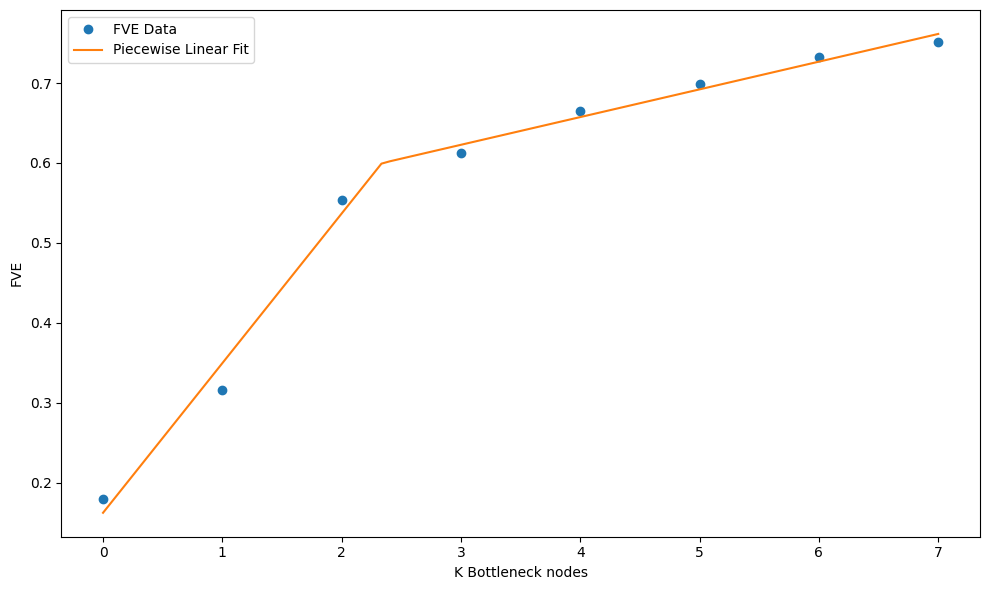

In [4]:
plt.figure(figsize=(10, 6), dpi=100)

input_data = np.load(f"{PIV_DIR}/PIVs.npy", allow_pickle=True)
d1 = np.load(f"{NN_DIR}/1d_ReconstructedPIVs.npy")
d2 = np.load(f"{NN_DIR}/2d_ReconstructedPIVs.npy")
d3 = np.load(f"{NN_DIR}/3d_ReconstructedPIVs.npy")
d4 = np.load(f"{NN_DIR}/4d_ReconstructedPIVs.npy")
d5 = np.load(f"{NN_DIR}/5d_ReconstructedPIVs.npy")
d6 = np.load(f"{NN_DIR}/6d_ReconstructedPIVs.npy")
d7 = np.load(f"{NN_DIR}/7d_ReconstructedPIVs.npy")
d8 = np.load(f"{NN_DIR}/8d_ReconstructedPIVs.npy")

# Calculate FVE dimensions
fve_dims = [FVE(input_data, d) for d in [d1, d2, d3, d4, d5, d6, d7, d8]]
x = np.arange(8)
y = np.array(fve_dims)

# Fit and plot
p, _ = optimize.curve_fit(piecewise_linear, x, y)
xd = np.linspace(0, 7, 100)

plt.plot(x, y, "o", label='FVE Data')
plt.plot(xd, piecewise_linear(xd, *p), label='Piecewise Linear Fit')
plt.xlabel("K Bottleneck nodes")
plt.ylabel("FVE")
plt.legend()
plt.tight_layout()
plt.show()

## Output model weights for PLUMED

Now that we have our trained model, we need to extract the learned weights and import them into PLUMED. We are going to load the latest checkpoint of our model, perform PCA, and write the weights of the model to a file so we can read it inside PLUMED's `ANN` module.

We need the location of the latest checkpoint file from training to extract the weights.

In [ ]:
CKPT_DIR = NN_DIR/"lightning_logs"/"version_24291045"/"checkpoints"/"__FILL__"

We will now load the weights from the trained model

In [ ]:
model_weights = torch.load(CKPT_DIR, map_location=torch.device('cpu'))['state_dict']

We will need the weights and biases of each layer, as well as running mean and variances of the batchnorm layers. We are going to create a dictionary of for the weights which we will format into a text file to append to the input script for PLUMED. We'll write a helper function that takes the weights of a layer and outputs a string.

In [33]:
def weights_to_str(layer, label):
    weights = model_weights[layer].numpy().flatten()
    weights = np.char.mod('%f', weights)
    weights_str = ",".join(weights)
    weights_str = label + weights_str

    return weights_str

Based on our encoder's architecture (linear -> batchnorm -> linear -> batchnorm -> linear -> batchnorm -> linear -> batchnorm), we'll extract the relevant parameters for the PLUMED inputs.

In [ ]:
encoder_blocks = [i for i in model_weights.keys() if re.match("encoder\.\d+\..*", i)]
for w in encoder_blocks:
    print(w)

In [ ]:
nn_arch={0: "linear0", 2: "batchnorm0", 3: "linear1", 5: "batchnorm1", 6: "linear2", 8: "batchnorm2", 9: "linear3", 11: "batchnorm3"}
linear_ws = ""
linear_bs = ""
batchnorm_gs = ""
batchnorm_bs = ""
batchnorm_es = ""
batchnorm_vs = ""
for i, layer in nn_arch.items():
    if layer[:-1] == "linear":
        linear_ws += weights_to_str(f"encoder.{i}.weight", f"WEIGHTS{layer[-1]}=")
        linear_ws += "\n"
        linear_bs += weights_to_str(f"encoder.{i}.bias", f"BIASES{layer[-1]}=")
        linear_bs += "\n"
    elif layer[:-1] == "batchnorm":
        batchnorm_gs += weights_to_str(f"encoder.{i}.weight", f"GAMMAS{layer[-1]}=")
        batchnorm_gs += "\n"
        batchnorm_bs += weights_to_str(f"encoder.{i}.bias", f"BETAS{layer[-1]}=")
        batchnorm_bs += "\n"
        batchnorm_es += weights_to_str(f"encoder.{i}.running_mean", f"EXPECTATIONS{layer[-1]}=")
        batchnorm_es += "\n"
        batchnorm_vs += weights_to_str(f"encoder.{i}.running_var", f"VARIANCES{layer[-1]}=")
        batchnorm_vs += "\n"


Before we compile the weights, we need to apply PCA to the latent variables to find the directions in the latent space with the largest variations. We will incorporate this as an additional linear layer inside the PLUMED script.

In [ ]:
LATENT_DATA = NN_DIR/"__FILL__" # point to the latent data from the model with the optimum latent dim

In [ ]:
from sklearn.decomposition import PCA

latent_data = np.load(LATENT_DATA)

pca = PCA()
pca_res = pca.fit_transform(latent_data)
pcs = (np.array(pca.components_)).flatten()
pca_weights_str = np.char.mod('%f', pcs)
pca_weights_str = ",".join(pca_weights_str)
linear_ws += "WEIGHTS4=" + pca_weights_str
linear_ws += "\n"

pcs_bias = np.zeros_like(pcs)
pcs_bias = np.char.mod('%f', pcs_bias)
pcs_bias = ",".join(pcs_bias)
linear_bs += "BIASES4=" + pca_weights_str
linear_bs += "\n"

Now that we have all the weights, we are going to compile our weights for incorporation into the PLUMED input file

In [ ]:
ANN_WEIGHTS = linear_ws + linear_bs + batchnorm_gs + batchnorm_bs + batchnorm_es + batchnorm_vs[:-1] # remove extra whitespace
print(ANN_WEIGHTS)

# Bias the simulation with PINES in PLUMED (`2.biased`)

The whitened CVs discovered by the autoencoders are used to bias the enhanced sampling MD runs using PBMetaD. A detailed tutorial for PBMetaD and descriptions of all the options are available [here](https://www.plumed.org/doc-v2.9/user-doc/html/_p_b_m_e_t_a_d.html). 

The MD simulation is stopped after 25 ns, and the new, biased trajectory is used to retrain the autoencoder for the next round. The biasing then continues with the updated CVs. This cycle continues until the learned CVs are converged.


In [ ]:
BIASED_DIR = BASE_DIR/"2.biased"
LATENT_DIM = latent_data.shape[1]

## PINES PLUMED input file

In our PLUMED input file, we have `PLUMED_PINES` block, which calculates PIVs given cartesian coordinates. It is identical to the one we used for the unbiased data. The `ANN` block takes the `PINES` block's outputs as inputs, and incorporates the architecture and the weights of our autoencoder, and finally a `PBMETAD` block which deposits biases along the discovered CVs. Note that the `ANN` block here has one extra layer compared to the autoencoder we trained because of the PCA layer that we manually appended.

The last piece of information we need, is the range of outputs from the PCA layer to determine the properties of the `GRID` used for `PBMETAD`

In [ ]:
GRID_MAXES = np.ceil(pca_res.max(axis=0)*10)/10 # up to a decimal
GRID_MAXES = np.char.mod('%f', GRID_MAXES)
GRID_MAXES = ",".join(GRID_MAXES)
GRID_MINS = np.floor(pca_res.min(axis=0)*10)/10
GRID_MINS = np.char.mod('%f', GRID_MINS)
GRID_MINS = ",".join(GRID_MINS)

In [ ]:
PLUMED_PINES = f"""
PINES ...
LABEL=pines
PRECISION=10000
NLIST
ONLYCROSS
REF_FILE=nvt.pdb
PINESATOMS=5
ATOMTYPES=NA,CL,OW,HW1,HW2
SFACTOR=1.0,1.0,1.0,1.0,1.0
SORT=1.0,1.0,1.0,1.0,1.0
SWITCH1={{RATIONAL R_0=0.38 MM=12 NN=6}}
SWITCH2={{RATIONAL R_0=0.35 MM=12 NN=6}}
SWITCH3={{RATIONAL R_0=0.41 MM=12 NN=6}}
SWITCH4={{RATIONAL R_0=0.40 MM=12 NN=6}}
SWITCH5={{RATIONAL R_0=0.28 MM=12 NN=6}}
NL_CUTOFF=5.0,1.5,1.5,1.5,1.5
NL_STRIDE=1.0,1.0,1.0,1.0,1.0
NL_SKIN=0.1,0.1,0.1,0.1,0.1
NL_CONSTANT_SIZE=15
WRITEPINESTRAJ
WRITEPINESSTRIDE=100000000
... PINES

ANN ...
LABEL=ann
ARG=pines.*
NUM_LAYERS=6
NUM_NODES=91,64,32,16,{LATENT_DIM},{LATENT_DIM}
ACTIVATIONS=BNTanh,BNTanh,BNTanh,BNTanh,Linear
{ANN_WEIGHTS}
APPLY_BATCH_NORM
... ANN

PBMETAD ...
ARG=ann.node-0,ann.node-1,ann.node-2 SIGMA=0.1,0.1,0.1 HEIGHT=1.2
TEMP=300 PACE=500 BIASFACTOR=2 LABEL=pb
FILE=hills_pc0.out,hills_pc2.out,hills_pc3.out
GRID_MIN={GRID_MINS} GRID_MAX={GRID_MAXES} GRID_BIN=5000,5000,5000
... PBMETAD

# monitor the cv and the metadynamics bias potential
PRINT STRIDE=1 ARG=ann.node-0,ann.node-1,ann.node-2,pb.bias FILE=colvar.out

"""

Save the plumed file

In [ ]:
with open(f"{BIASED_DIR}/plumed_parametrized.dat", "w") as f:
    f.write(PLUMED_PINES)

## Run the biased simulation

In [ ]:
# copy the pdb file from the nvt simulation for refrence
subprocess.run(f"cp{EM_DIR/"nvt.pdb"} {BIASED_DIR/"nvt.pdb"}")
# for round 1
with cd(f"{BIASED_DIR}"):
    subprocess.run(f"{GMX_EXEC} mdrun -s {MD_DIR/"md.tpr"} -deffnm biased -plumed plumed_parametrized.dat -cpi {MD_DIR/"md.cpt"}")
# for subsequent rounds
#with cd(f"{BIASED_DIR}"):
    #subprocess.run(f"{GMX_EXEC} mdrun -s {MD_DIR/"md.tpr"} -deffnm biased -plumed plumed_parametrized.dat -cpi biased.cpt")

Another important criteria for determining wether the sampling at each round has been sufficient is to look at the explored CV space and compare it to the previous rounds.

In [ ]:
def get_colvardata(filename_colvar):
    with open(filename_colvar,'r') as colvar_file:
        colvar_labels = colvar_file.readline().split()[2:]
    colvar_data=np.loadtxt(filename_colvar)
    return (colvar_data,colvar_labels)


(colvar_data_un,labels_un)=get_colvardata(f"{MD_DIR}/colvar.data")
(colvar_data_b,labels_b)=get_colvardata(f"{BIASED_DIR}/colvar.out")

plt.figure(figsize=(8, 6), dpi=100)

plt.plot(colvar_data_b[::250, 1], colvar_data_b[::250, 2], '.', c='red', label='biased') # plotting every 250 frames
plt.plot(colvar_data_un[:,1], colvar_data_un[:,2], '.', c='blue', label='unbiased')
plt.xlabel("Na-Cl distance [nm]")
plt.ylabel("Coord. No. of Na")
plt.legend()
plt.show()

# Convergence criteria

PINES-learned CVs are considered converged if i) the dimensionality of the bottleneck layer is constant between consecutive rounds and ii) the cosine similarity between the learned CVs of two consecutive rounds is greater than 0.9. This is calculated by projecting the current round’s simulation into the current and previous round’s CVs and calculating the cosine similarity. 

<figure align="center">
  <img src="./notebook_src/pines3.png" alt="elbow plot">
  <figcaption>Fig. 3: Elbow plots showing the convergence of the latent space dimensionality. As we go through rounds of applying PINES, the knee of the FVE plots converges to a fixed value, indicating that PINES has efficiently learned the underlying latent space. Figure adapted from 10.1021/acs.jctc.3c00923, copyright ACS.
</figcaption>
</figure>

<figure align="center">
  <img src="./notebook_src/pines4.png" alt="cos sim">
  <figcaption>Fig. 4: Similar to the elbow plot, as we go through rounds of applying PINES the discovered CVs converge, leading to the cosine similarity of the discovered CVs between two consecutive round to be close to 1. Figure adapted from 10.1021/acs.jctc.3c00923, copyright ACS.
</figcaption>
</figure>

# Resources

* PINES paper: Herringer, Nicholas SM; Dasetty, Siva; Gandhi, Diya; Lee, Junhee; Ferguson, Andrew L. "Permutationally Invariant Networks for Enhanced Sampling (PINES): Discovery of Multi-Molecular and Solvent-Inclusive Collective Variables." Journal of Chemical Theory and Computation 2024 20 (1), 178-198. [link](https://pubs.acs.org/doi/10.1021/acs.jctc.3c00923)

* [GitHub repo](https://github.com/Ferg-Lab/pines)

* [List of input parameters](https://github.com/Ferg-Lab/pines/blob/main/parameters.md)